# Usage - redo pca

In [ ]:
#TODO: create class with R and C

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import napari
import os
from MGFeatures import ER_length, count_organelles, img_from_tiles, label_cells, mask_it, draw_bbox
from skimage import io
import gc
from skimage.measure import regionprops
import pandas as pd
from joblib import Parallel, delayed

%load_ext autoreload
%autoreload 2

In [3]:
def get_area(labels, labels_list): 
    areas = []
    for i in labels_list:
        area = np.count_nonzero(labels == i)
        areas.append(area)
    areas = np.array(areas)
    return areas

In [6]:
def make_properties(sl_num, return_labels=False):
    properties = {}
    # get labels and binary images
    cell_folder = r'X:\Hanyi\MG\cell-png'
    cell, imageshape = img_from_tiles(cell_folder, sl_num, cell=True, imageshape=None)
    cell_labels = label_cells(cell)
    
    heterochromatin_folder = r'X:\Hanyi\MG\heterochromatin' # faster if from ssd?
    lipids_folder = r'X:\Hanyi\MG\lipids'
    lysosomes_folder = r'X:\Hanyi\MG\lysosomes'
    mitochondria_folder = r'X:\Hanyi\MG\mitochondria'
    nucleus_folder = r'X:\Hanyi\MG\nucleus'
    organelles_folder = r'X:\Hanyi\MG\organelles_cyto'

    heterochromatin_labels = mask_it(cell_labels, img_from_tiles(heterochromatin_folder, sl_num, imageshape=imageshape))
    lipids_labels = mask_it(cell_labels, img_from_tiles(lipids_folder, sl_num, imageshape=imageshape))
    lysosomes_labels = mask_it(cell_labels, img_from_tiles(lysosomes_folder, sl_num, imageshape=imageshape))
    mitochondria_labels = mask_it(cell_labels, img_from_tiles(mitochondria_folder, sl_num, imageshape=imageshape))
    nucleus_labels = mask_it(cell_labels, img_from_tiles(nucleus_folder, sl_num, imageshape=imageshape))
    organelles_labels = mask_it(cell_labels, img_from_tiles(organelles_folder, sl_num, imageshape=imageshape))

    ER_folder = r'X:\Hanyi\MG\ER'
    ER = img_from_tiles(ER_folder, sl_num, imageshape=imageshape)
    
    # calculations
    labels_list = np.unique(cell_labels)[1:]

    properties['cell_area'] = get_area(cell_labels, labels_list)
    properties['organelles_area'] = get_area(organelles_labels, labels_list)
    properties['nucleus_area'] = get_area(nucleus_labels, labels_list)
    properties['heterochromatin_area'] = get_area(heterochromatin_labels, labels_list)
    properties['lipids_area'] = get_area(lipids_labels, labels_list)
    properties['mitochondria_area'] = get_area(mitochondria_labels, labels_list)
    properties['lysosomal_area'] = get_area(lysosomes_labels, labels_list)
    
    properties['empty_area'] = properties['cell_area'] - properties['nucleus_area'] - properties['organelles_area']
    properties['cytoplasm_area'] = properties['cell_area'] - properties['nucleus_area']
    
    properties['ER_lengths'] = ER_length(ER, cell_labels)
        
    
    properties['heterochormatin_nucleus_R'] = properties['heterochromatin_area']/properties['nucleus_area']
    properties['lipids_cytoplasm_R'] = properties['lipids_area']/properties['cytoplasm_area'] #foam cells
    properties['empty_organelles_R'] = properties['empty_area']/properties['organelles_area']
    properties['empty_nucleus_R'] = properties['empty_area']/properties['nucleus_area'] #unknown cells
    properties['cytoplasm_nucleus_R'] = properties['cytoplasm_area']/properties['nucleus_area'] #t cells
    properties['mitochondria_cytoplasm_R'] = properties['mitochondria_area']/properties['cytoplasm_area']
    properties['lysosomes_cytoplasm_R'] = properties['lysosomal_area']/properties['cytoplasm_area'] #lysosomes positive cells
    
    properties['ERlen_cytoplasm_R'] = properties['ER_lengths']/properties['cytoplasm_area']
    
    #properties['lysosomes_count'] = count_organelles(lysosomes_labels, cell_labels)
    
    properties['sl_num'] = np.array([sl_num]*len(labels_list))
    
    bbox_rects = []
    for region in regionprops(cell_labels):
        bbox = region.bbox
        bbox_rect = draw_bbox(bbox)
        bbox_rects.append(bbox_rect)
    properties['bbox_rects'] = bbox_rects # remove np.array
    
    if return_labels==True:
        return properties, (cell_labels, heterochromatin_labels, lipids_labels, lysosomes_labels, mitochondria_labels, nucleus_labels, organelles_labels, ER)
    else:
        return properties

In [7]:
properties08 = Parallel(n_jobs=9, verbose=True)(delayed(make_properties)(i) for i in range(9))

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   9 | elapsed: 19.7min remaining: 68.8min
[Parallel(n_jobs=9)]: Done   9 out of   9 | elapsed: 50.0min finished


In [5]:
# TODO: change bboxrects to list
# for properties in properties08:
#     properties['bbox_rects'] = list(properties['bbox_rects'])

In [8]:
properties916 = Parallel(n_jobs=8, verbose=True)(delayed(make_properties)(i) for i in range(9, 17))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed: 27.9min remaining: 83.7min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 44.5min finished


In [9]:
# for properties in properties916:
#     properties['bbox_rects'] = list(properties['bbox_rects'])

In [9]:
features08 = [pd.DataFrame.from_dict(properties08[i]) for i in range(9)]

In [10]:
features916 = [pd.DataFrame.from_dict(properties916[i]) for i in range(8)]

In [11]:
features08 = pd.concat(features08, ignore_index=True)
features916 = pd.concat(features916, ignore_index=True)
_featuresall = pd.concat([features08, features916], ignore_index=True)

In [12]:
_featuresall.to_excel('featuresall_v04.xlsx', index=False)

In [13]:
featuresall = _featuresall.dropna()

In [38]:
filt = featuresall.isin([np.inf])
featuresall = featuresall[~filt]
featuresall = featuresall.dropna()

In [39]:
featuresall = featuresall.reset_index(drop=True)

In [43]:
featuresall

,cell_area,organelles_area,nucleus_area,heterochromatin_area,lipids_area,mitochondria_area,lysosomal_area,empty_area,cytoplasm_area,ER_lengths,heterochormatin_nucleus_R,lipids_cytoplasm_R,empty_organelles_R,empty_nucleus_R,cytoplasm_nucleus_R,mitochondria_cytoplasm_R,lysosomes_cytoplasm_R,ERlen_cytoplasm_R,sl_num,bbox_rects
0,80980,28480,39316,17268,3376,604,5896,13184,41664,1576.621487,0.439210,0.081029,0.462921,0.335334,1.059721,0.014497,0.141513,0.037841,0,"[[18722, 28490], [19040, 28490], [19040, 28900..."
1,68545,16588,41028,16854,0,965,0,10929,27517,811.754394,0.410793,0.000000,0.658850,0.266379,0.670688,0.035069,0.000000,0.029500,0,"[[19290, 38352], [19644, 38352], [19644, 38726..."
2,87034,33185,44767,16235,0,5547,0,9082,42267,1701.741323,0.362656,0.000000,0.273678,0.202873,0.944155,0.131237,0.000000,0.040262,0,"[[19835, 16680], [20143, 16680], [20143, 17411..."
3,74590,26943,17393,9114,0,4486,0,30254,57197,1021.955404,0.524004,0.000000,1.122889,1.739435,3.288507,0.078431,0.000000,0.017867,0,"[[19850, 30159], [20069, 30159], [20069, 30981..."
4,130431,63809,50680,20881,0,5370,4077,15942,79751,4836.249235,0.412017,0.000000,0.249839,0.314562,1.573619,0.067335,0.051122,0.060642,0,"[[20229, 33819], [20851, 33819], [20851, 34536..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,162785,73839,59104,26995,8567,9625,0,29842,103681,3982.830848,0.456737,0.082628,0.404150,0.504907,1.754213,0.092833,0.000000,0.038414,16,"[[74325, 53410], [74862, 53410], [74862, 54199..."
919,104354,46189,49812,19212,0,4640,0,8353,54542,2986.833812,0.385690,0.000000,0.180844,0.167691,1.094957,0.085072,0.000000,0.054762,16,"[[74420, 50570], [74742, 50570], [74742, 51186..."
920,257260,171828,76624,31989,109336,4108,0,8808,180636,259.663993,0.417480,0.605284,0.051261,0.114951,2.357434,0.022742,0.000000,0.001437,16,"[[74490, 51408], [75166, 51408], [75166, 52020..."
921,48279,23758,12364,5365,0,4578,0,12157,35915,964.205186,0.433921,0.000000,0.511701,0.983258,2.904804,0.127468,0.000000,0.026847,16,"[[74975, 53573], [75242, 53573], [75242, 53907..."


In [40]:
features_impt = featuresall.drop(columns=['cell_area', 'organelles_area', 'nucleus_area', 'heterochromatin_area', 'lipids_area', 'cytoplasm_area', 'ER_lengths', 'bbox_rects', 'sl_num', 'empty_area']) #also ER!

In [41]:
features_impt = features_impt.reset_index(drop=True)

In [42]:
features_impt

,mitochondria_area,lysosomal_area,heterochormatin_nucleus_R,lipids_cytoplasm_R,empty_organelles_R,empty_nucleus_R,cytoplasm_nucleus_R,mitochondria_cytoplasm_R,lysosomes_cytoplasm_R,ERlen_cytoplasm_R
0,604,5896,0.439210,0.081029,0.462921,0.335334,1.059721,0.014497,0.141513,0.037841
1,965,0,0.410793,0.000000,0.658850,0.266379,0.670688,0.035069,0.000000,0.029500
2,5547,0,0.362656,0.000000,0.273678,0.202873,0.944155,0.131237,0.000000,0.040262
3,4486,0,0.524004,0.000000,1.122889,1.739435,3.288507,0.078431,0.000000,0.017867
4,5370,4077,0.412017,0.000000,0.249839,0.314562,1.573619,0.067335,0.051122,0.060642
...,...,...,...,...,...,...,...,...,...,...
918,9625,0,0.456737,0.082628,0.404150,0.504907,1.754213,0.092833,0.000000,0.038414
919,4640,0,0.385690,0.000000,0.180844,0.167691,1.094957,0.085072,0.000000,0.054762
920,4108,0,0.417480,0.605284,0.051261,0.114951,2.357434,0.022742,0.000000,0.001437
921,4578,0,0.433921,0.000000,0.511701,0.983258,2.904804,0.127468,0.000000,0.026847


## Analysis

In [19]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [45]:
scaler = StandardScaler()
std = scaler.fit_transform(features_impt)
pca = PCA()
pca.fit(std)

PCA()

Text(0, 0.5, 'Cumul explained var')

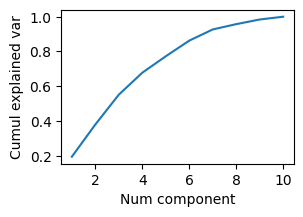

In [46]:
plt.figure(figsize=(3, 2))
plt.plot(range(1,11), pca.explained_variance_ratio_.cumsum())
plt.xlabel('Num component')
plt.ylabel('Cumul explained var')

Text(0, 0.5, 'Explained var')

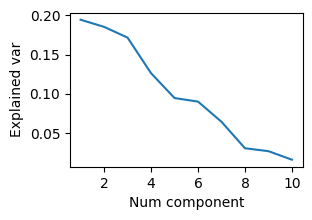

In [47]:
plt.figure(figsize=(3, 2))
plt.plot(range(1,11), pca.explained_variance_ratio_)
plt.xlabel('Num component')
plt.ylabel('Explained var')

In [48]:
pca = PCA(n_components=6)
pca.fit(std)
scores_pca = pca.transform(std)

In [49]:
wcss = []
for i in range(1, 21):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

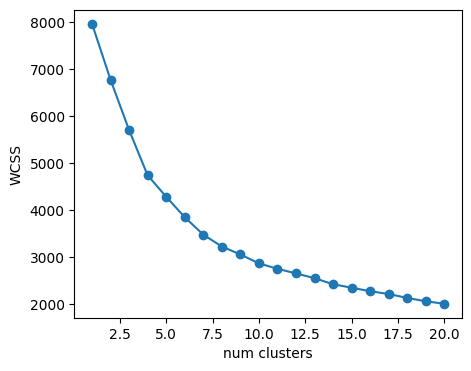

In [50]:
plt.figure(figsize = (5,4))
plt.plot(range(1, 21), wcss, marker='o')
plt.xlabel('num clusters')
plt.ylabel('WCSS')
plt.show()

In [51]:
kmeans_pca = KMeans(n_clusters=6, init='k-means++', random_state=42)

In [52]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=6, random_state=42)

In [57]:
features_pca = pd.concat([featuresall, pd.DataFrame(scores_pca)], axis=1)
features_pca.columns.values[-6:] = ['Component1', 'Component2', 'Component3', 'Component4', 'Component5', 'Component6']
features_pca['pca_kmeans_labels'] = kmeans_pca.labels_

In [58]:
features_pca.to_excel('features_pca_v04.xlsx')
# features_pca = pd.read_excel('features_pca_v03.xlsx') #when import bbox rects becomes string

In [59]:
features_pca

,cell_area,organelles_area,nucleus_area,heterochromatin_area,lipids_area,mitochondria_area,lysosomal_area,empty_area,cytoplasm_area,ER_lengths,...,ERlen_cytoplasm_R,sl_num,bbox_rects,Component1,Component2,Component3,Component4,Component5,Component6,pca_kmeans_labels
0,80980,28480,39316,17268,3376,604,5896,13184,41664,1576.621487,...,0.037841,0,"[[18722, 28490], [19040, 28490], [19040, 28900...",1.909811,3.328046,0.740695,0.152476,0.831184,0.400383,3
1,68545,16588,41028,16854,0,965,0,10929,27517,811.754394,...,0.029500,0,"[[19290, 38352], [19644, 38352], [19644, 38726...",0.563104,-0.623807,-0.956146,0.008427,0.372023,0.068793,1
2,87034,33185,44767,16235,0,5547,0,9082,42267,1701.741323,...,0.040262,0,"[[19835, 16680], [20143, 16680], [20143, 17411...",-1.690089,-0.480220,-0.386549,-0.702861,0.946014,-0.833849,2
3,74590,26943,17393,9114,0,4486,0,30254,57197,1021.955404,...,0.017867,0,"[[19850, 30159], [20069, 30159], [20069, 30981...",-2.297507,-1.172996,2.747477,3.422615,-1.032738,3.508137,0
4,130431,63809,50680,20881,0,5370,4077,15942,79751,4836.249235,...,0.060642,0,"[[20229, 33819], [20851, 33819], [20851, 34536...",-0.553557,1.699793,0.408347,-0.579880,0.647357,0.350377,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,162785,73839,59104,26995,8567,9625,0,29842,103681,3982.830848,...,0.038414,16,"[[74325, 53410], [74862, 53410], [74862, 54199...",-2.090838,-0.647891,0.927323,0.006051,0.263660,-0.198301,2
919,104354,46189,49812,19212,0,4640,0,8353,54542,2986.833812,...,0.054762,16,"[[74420, 50570], [74742, 50570], [74742, 51186...",-0.915730,-0.358991,-0.767614,-0.894873,0.481490,-0.275842,2
920,257260,171828,76624,31989,109336,4108,0,8808,180636,259.663993,...,0.001437,16,"[[74490, 51408], [75166, 51408], [75166, 52020...",1.802058,-1.886747,1.586878,-0.890759,0.555349,-1.493941,4
921,48279,23758,12364,5365,0,4578,0,12157,35915,964.205186,...,0.026847,16,"[[74975, 53573], [75242, 53573], [75242, 53907...",-2.192753,-0.938794,1.549819,1.350093,-0.067138,1.310346,0


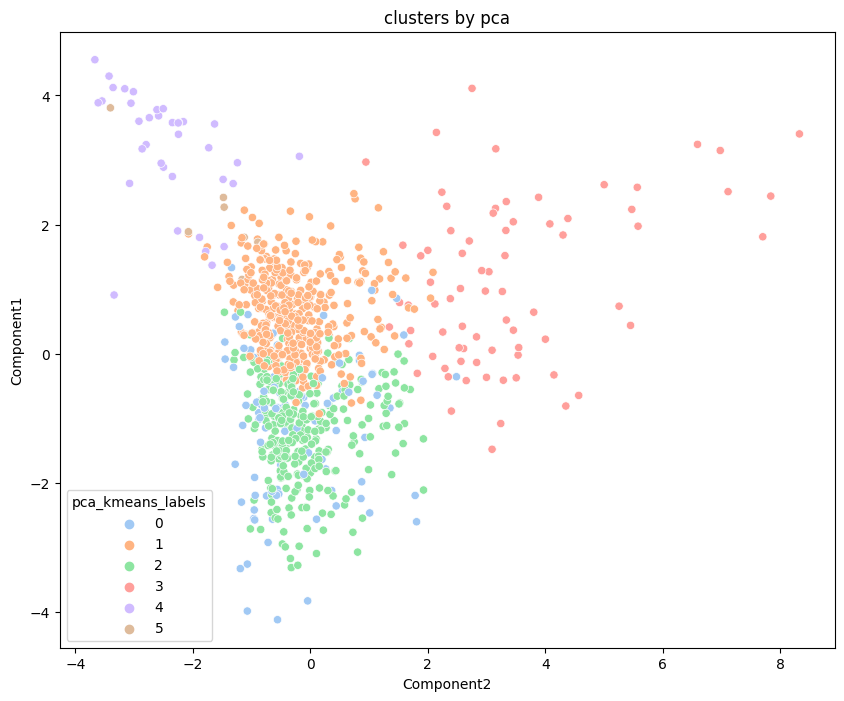

In [60]:
# x_axis = features_pca['Component4']
# y_axis = features_pca['Component3']
plt.figure(figsize=(10,8))
sns.scatterplot(data=features_pca, x='Component2', y='Component1', hue='pca_kmeans_labels', palette='pastel')
# plt.ylim(-2.5, 5)
# plt.xlim(-5, 5)
plt.title('clusters by pca')
plt.show()

In [61]:
pca_kmeans_labels = features_pca['pca_kmeans_labels'].values.tolist()

In [62]:
cmap = {0:'red',
       1:'yellow',
       2:'blue',
       3:'green',
       4:'orange',
       5:'magenta'}

In [63]:
clabels = [cmap.get(k) for k in pca_kmeans_labels]

In [89]:
viewer = napari.Viewer()

C:\Users\jiangh\.conda\envs\MG\lib\site-packages\napari\plugins\_plugin_manager.py:549: UserWarning: Plugin 'napari-time-slicer' has already registered a function widget 'convert to 2d timelapse' which has now been overwritten
  warn(message=warn_message)
C:\Users\jiangh\.conda\envs\MG\lib\site-packages\napari\plugins\_plugin_manager.py:549: UserWarning: Plugin 'napari-segment-blobs-and-things-with-membranes' has already registered a function widget 'gaussian blur' which has now been overwritten
  warn(message=warn_message)
C:\Users\jiangh\.conda\envs\MG\lib\site-packages\napari\plugins\_plugin_manager.py:549: UserWarning: Plugin 'napari-segment-blobs-and-things-with-membranes' has already registered a function widget 'subtract background' which has now been overwritten
  warn(message=warn_message)
C:\Users\jiangh\.conda\envs\MG\lib\site-packages\napari\plugins\_plugin_manager.py:549: UserWarning: Plugin 'napari-segment-blobs-and-things-with-membranes' has already registered a function

In [90]:
viewer.add_shapes(data=features_pca['bbox_rects'],
                  # properties=pca_kmeans_labels,
                 face_color=clabels
                 )

<Shapes layer 'Shapes' at 0x174ca9dea10>

## visualise seaborn

In [65]:
features_pca.columns

Index(['cell_area', 'organelles_area', 'nucleus_area', 'heterochromatin_area',
       'lipids_area', 'mitochondria_area', 'lysosomal_area', 'empty_area',
       'cytoplasm_area', 'ER_lengths', 'heterochormatin_nucleus_R',
       'lipids_cytoplasm_R', 'empty_organelles_R', 'empty_nucleus_R',
       'cytoplasm_nucleus_R', 'mitochondria_cytoplasm_R',
       'lysosomes_cytoplasm_R', 'ERlen_cytoplasm_R', 'sl_num', 'bbox_rects',
       'Component1', 'Component2', 'Component3', 'Component4', 'Component5',
       'Component6', 'pca_kmeans_labels'],
      dtype='object')

In [66]:
features_plot = features_pca[['heterochormatin_nucleus_R',
                             'lipids_cytoplasm_R',
                             'cytoplasm_nucleus_R',
                              'empty_organelles_R',
                             'ERlen_cytoplasm_R',
                             'pca_kmeans_labels',
                             'mitochondria_cytoplasm_R',
                             'lysosomes_cytoplasm_R',
                             'mitochondria_area',
                             'empty_nucleus_R'
                              ]]

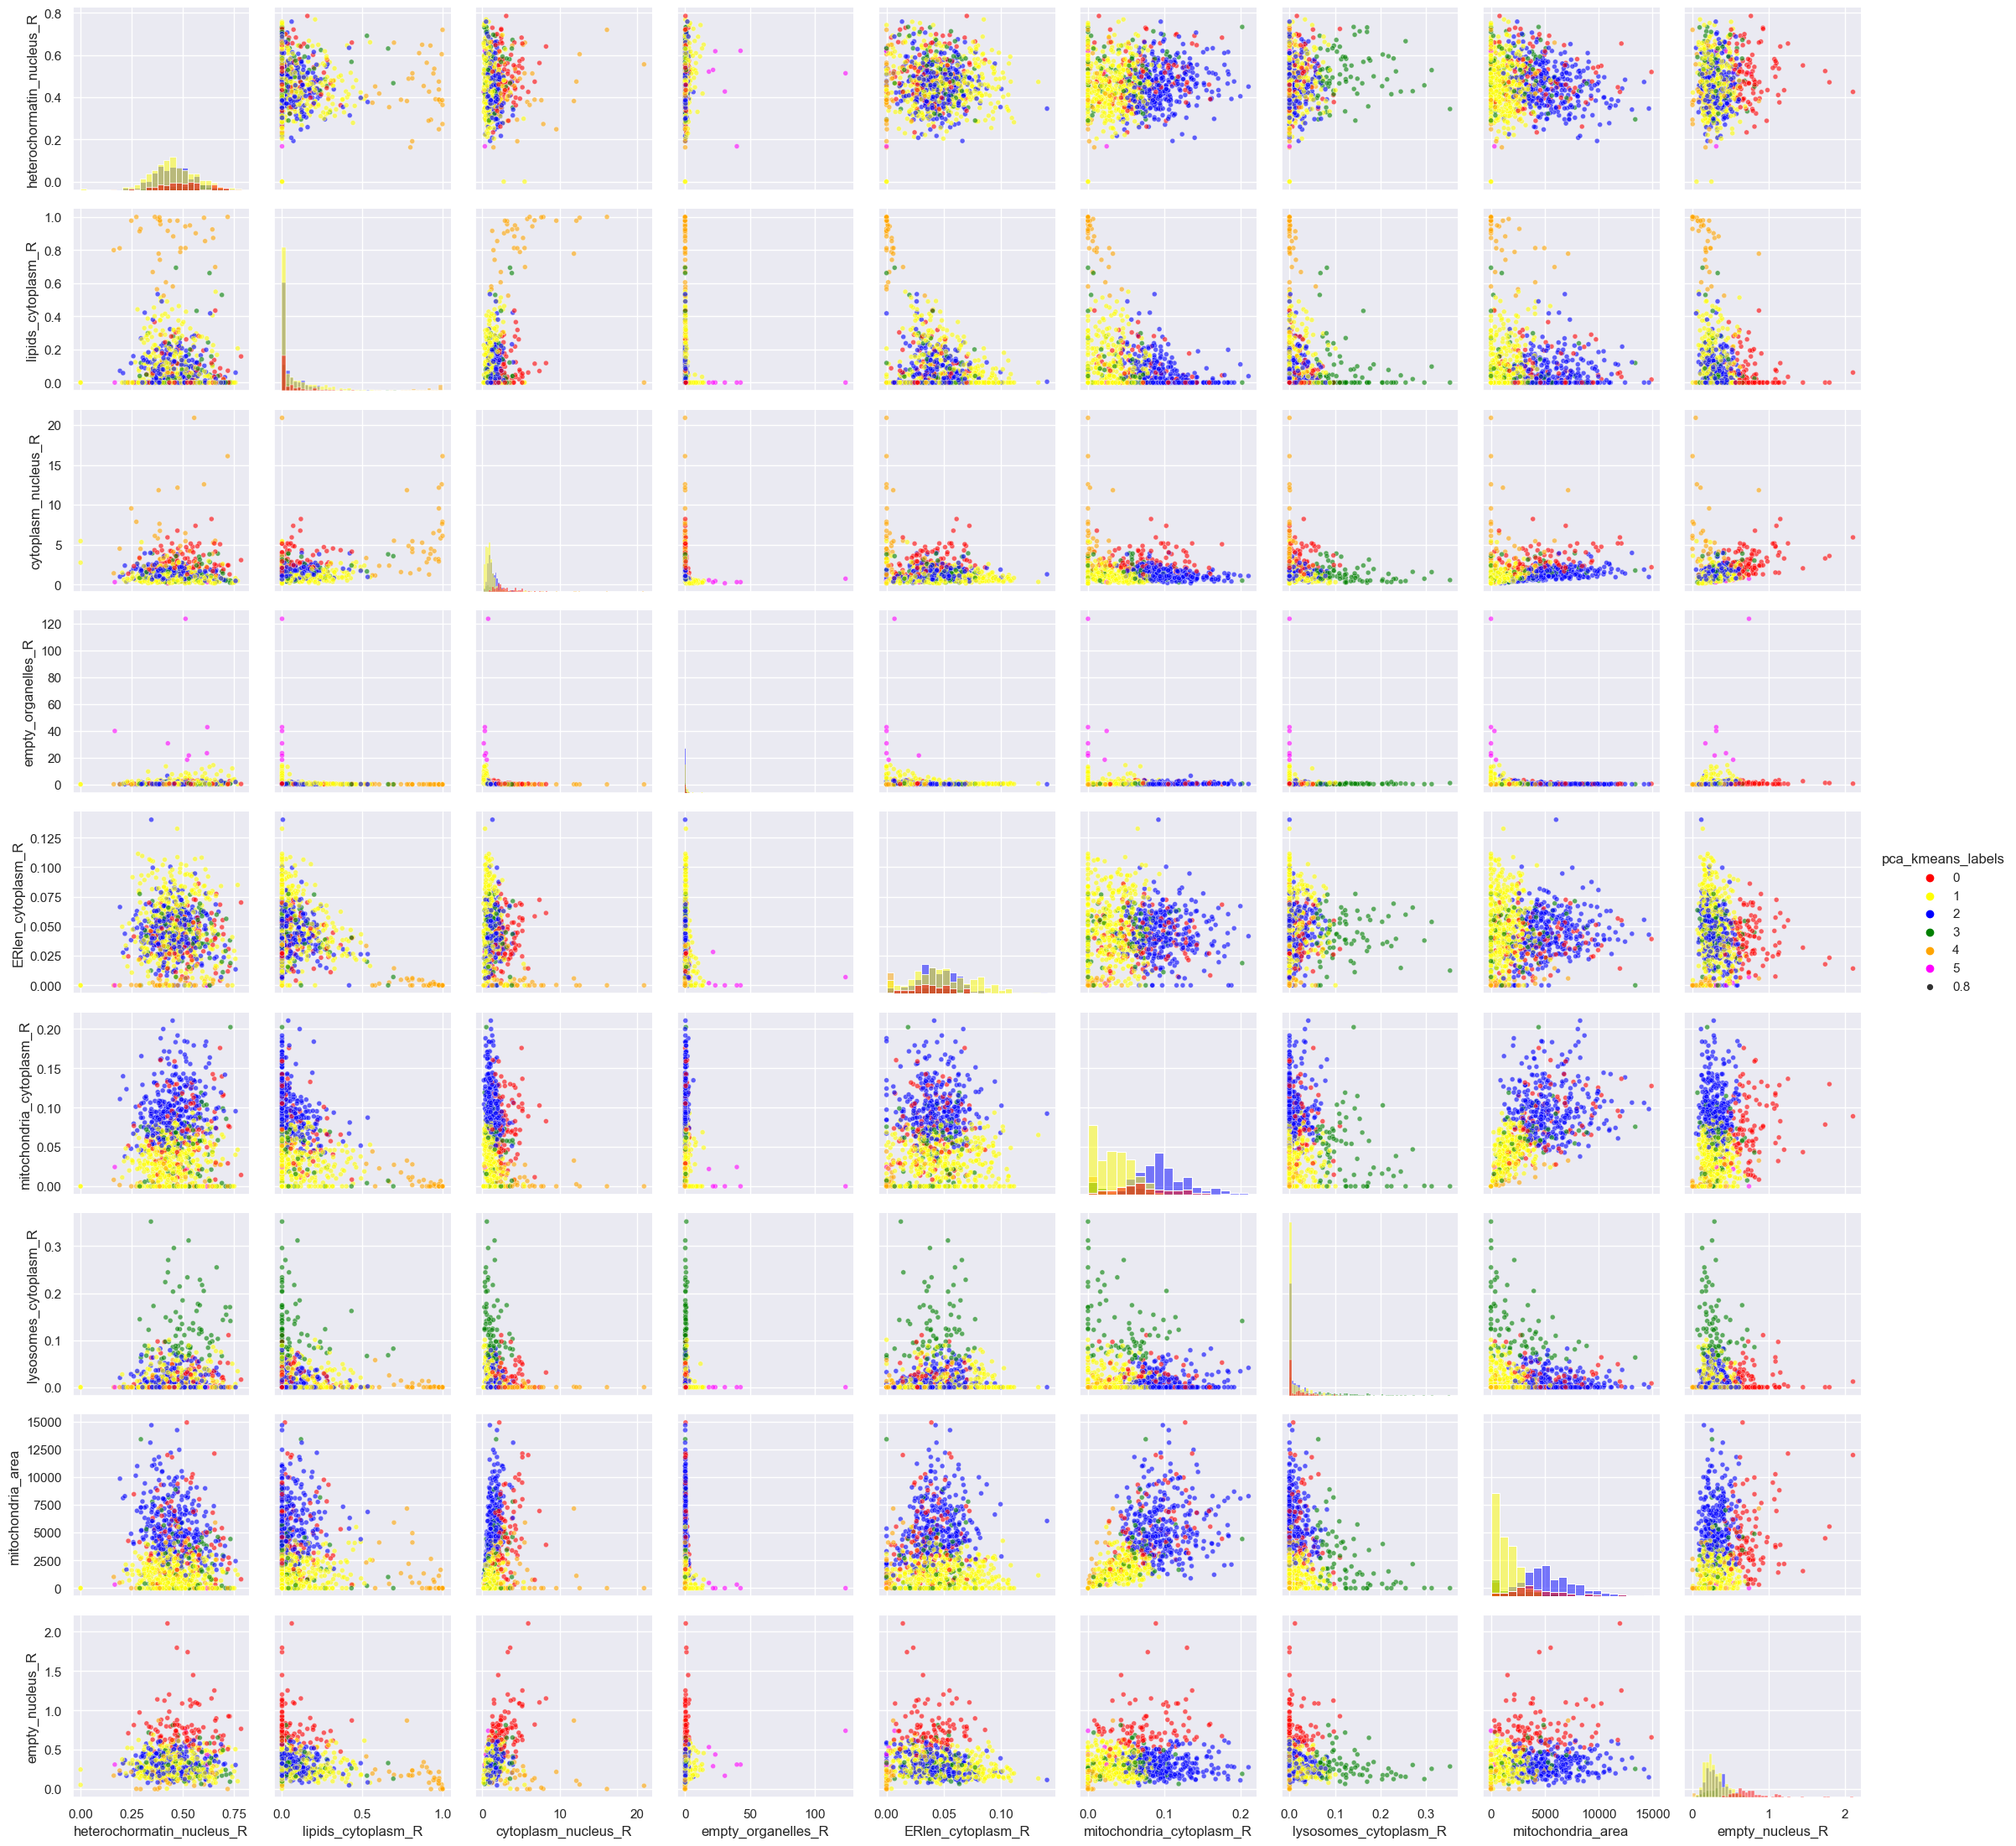

In [67]:
sns.set(rc={'figure.figsize':(100,120)})
g = sns.PairGrid(features_plot,
                 hue='pca_kmeans_labels',
                 palette=cmap
                )

g.map_offdiag(sns.scatterplot, alpha=0.6, size=0.8)
g.map_diag(sns.histplot)
g.add_legend()
plt.show()

In [68]:
g.savefig('plotMG_v04.png')